<a href="https://colab.research.google.com/github/wswager/expected_goals/blob/main/data_modeling/expected_goals_data_modeling_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Capstone Project Submission**

* Student Name: Wes Swager
* Student Pace: Full Time
* Instructor Name: Claude Fried
* Scheduled Project Review Date/Time
    * Friday, June, 11, 2:30pm CST

# Data Modeling Notebook

<a id = 'packages'></a>
# Packages

In [ ]:
# Drive  and IO to access saved data
from google.colab import drive, files
drive.mount('/content/drive')

import io

# Pandas for Dataframes
import pandas as pd

# Numpy and for mathematical functions
import numpy as np

# Scikit-learn and XGBoost for modeling
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve, f1_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.ensemble import VotingClassifier

import xgboost as xgb

# Matplotlib and Seaborn for visualizations

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

import seaborn as sns
sns.set(style = 'darkgrid', context = 'talk')

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id = 'data'></a>
# Data

1. Data sourced from [StatsBomb Open Data](https://github.com/statsbomb/open-data)
2. Data extracted in [expected_goals_data_extraction_notebook](https://github.com/wswager/expected_goals/blob/main/data_extraction/expected_goals_data_extraction_notebook.ipynb)
3. Data organized in [expected_goals_data_organization_notebook](https://github.com/wswager/expected_goals/blob/main/data_organization/expected_goals_data_organization_notebook.ipynb)
4. Features engineered in [expected_goals_feature_engineering_notebook](https://github.com/wswager/expected_goals/blob/main/feature_engineering/expected_goals_feature_engineering_notebook.ipynb)
5. Data cleaned in [expected_goals_data_cleaning_notebook](https://github.com/wswager/expected_goals/blob/main/data_cleaning/expected_goals_data_cleaning_notebook.ipynb)
6. Data preprocessed in [expected_goals_data_preprocessing_notebook](https://github.com/wswager/expected_goals/blob/main/data_preprocessing/expected_goals_data_preprocessing_notebook.ipynb)

In [ ]:
# Import dataframes extracted from
# expected_goals_data_extraction_notebook

preprocessed_data = pd.read_csv('/content/drive/MyDrive/flatiron/expected_goals/data_preprocessing/preprocessed_data.csv')

In [ ]:
preprocessed_data = preprocessed_data.iloc[: , 1:]

In [ ]:
preprocessed_data.head()

,Head,Left Foot,Other Bodypart,Right Foot,Half Volley,Normal Shot,Volley,Open Play Shot,Set Piece - Direct Free Kick,Set Piece - Penalty,Cross,Cut Back,Ground Pass,High Pass,Low Pass,Through Ball,Unassisted,Open Play - Assist,Open Play - Counter Attack,Open Play - Keeper,Open Play Assist,Set Piece - Corner,Set Piece - Free Kick,Set Piece - Goal Kick,Set Piece - Kick Off,Set Piece - Throw In,shot_distance,shot_angle,goal,first_time
0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0.175922,0.658944,0,0
1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0.115995,0.302556,0,0
2,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0.384077,0.536556,0,0
3,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.511523,0.444389,0,0
4,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.395571,0.416278,0,0


# Modeling

## Preparation

### Drop Target Feature

In [ ]:
# Define target feature, 'goal'

y = preprocessed_data['goal']

# Drop target feature 'goal' from preprocessed_data

x = preprocessed_data.drop(['goal'],
                           axis = 1)

### Train, Test Split

In [ ]:
# Split data in train and test

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 13)

### Functions

In [ ]:
# Use Grid Search to find the best parameters for model

def model_grid(model, params):
    lr_grid = GridSearchCV(model, 
                           params,
                           refit = True, 
                           cv = 5)
    lr_grid.fit(x_train, y_train)
    display(lr_grid.best_params_)

In [ ]:
# Generate model report with precision, recall, and F1

def model_report(train,
                 test,
                 train_prediction,
                 test_prediction):
  report_train = pd.DataFrame(classification_report(train,
                                                    train_prediction,
                                                    output_dict = True))
  report_train = report_train.rename(columns = {'0' : 'Train - False',
                                                '1' : 'Train - True'})
  report_train = report_train.drop(['accuracy',
                                    'macro avg',
                                    'weighted avg'],
                                   axis = 1)
  
  report_test = pd.DataFrame(classification_report(test,
                                                   test_prediction,
                                                   output_dict = True))
  
  report = report_train
  report['Test - False'] = report_test['0']
  report['Test - True'] = report_test['1']
  
  report = report[['Train - False',
                   'Test - False',
                   'Train - True',
                   'Test - True']]
  
  display(report)

In [ ]:
# Visualize Confusion Matrix
# Visually representing the dispersal of True Positives, True Negatives,
# False Positives, and False Negatives

def model_matrix(train,
                 test,
                 train_prediction,
                 test_prediction):
    train_matrix = confusion_matrix(train,
                                    train_prediction)
    test_matrix = confusion_matrix(test,
                                    test_prediction)
    
    f, (ax1, ax2) = plt.subplots(1, 2,
                                 figsize = (25, 10))
    
    sns.heatmap(train_matrix,
                annot = True,
                ax = ax1)
    sns.heatmap(test_matrix,
                annot = True,
                ax = ax2)

    ax.set_title('Confusion Matrix')
    plt.show()

In [ ]:
 # Calculate model ROC AUC

 # Visualize ROC Curve

def model_roc(train,
              test,
              train_probability,
              test_probability):
  print('Train - Area Under the Curve:',
        round(roc_auc_score(train,
                            train_probability[:,1]),2))
  print('Test - Area Under the Curve:',
        round(roc_auc_score(test,
                            test_probability[:,1]),2))
  
  fpr_train, tpr_train, thresholds_train = roc_curve(train, 
                                                     train_probability[:,1])
  fpr_test, tpr_test, thresholds_test = roc_curve(test, 
                                                     test_probability[:,1])
    
  f, ax = plt.subplots(figsize = (10, 10))
  
  plt.plot(fpr_train,
           tpr_train,
           'aqua',
           label = 'Train')
  
  plt.plot(fpr_test,
           tpr_test,
           'lightcoral',
           label = 'Test')
  
  plt.plot([0, 1],
           [0, 1],
           'purple')
  
  ax.set_title('Receiver Operating Characteristic')
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.legend(bbox_to_anchor = (1.05, 1),
            loc = 2,
            borderaxespad = 0);

## Logistic Regression

In [ ]:
# Define Model

lr = LogisticRegression()

### Define Parameters

In [ ]:
# Define lr parameters for Grid Search

lr_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}

# Use Grid Search to find the best parameters for lr

model_grid(lr, lr_params)

{'C': 1000, 'solver': 'lbfgs'}

In [ ]:
lr_best = LogisticRegression(C = 1000,
                             solver = 'lbfgs')

# Refine lr parameters for Grid Search

lr_params = {'C': [900, 1000, 1500, 2000],
             'penalty' : ['l2', 'none']}

model_grid(lr_best, lr_params)

{'C': 1000, 'penalty': 'l2'}

In [ ]:
# Define best paramters for lr

lr_best = LogisticRegression(C = 1000,
                             penalty = 'l2',
                             solver = 'lbfgs')

### Fit Model

In [ ]:
lr_best.fit(x_train,
            y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr_train_predict = lr_best.predict(x_train)
lr_train_probability = lr_best.predict_proba(x_train)

lr_test_predict = lr_best.predict(x_test)
lr_test_probability = lr_best.predict_proba(x_test)

### Results

In [ ]:
model_report(y_train,
             y_test,
             lr_train_predict,
             lr_test_predict)

,Train - False,Test - False,Train - True,Test - True
precision,0.897701,0.896266,0.722222,0.500000
recall,0.996552,0.992647,0.073171,0.060150
f1-score,0.944547,0.941997,0.132879,0.107383
support,4350.000000,1088.000000,533.000000,133.000000


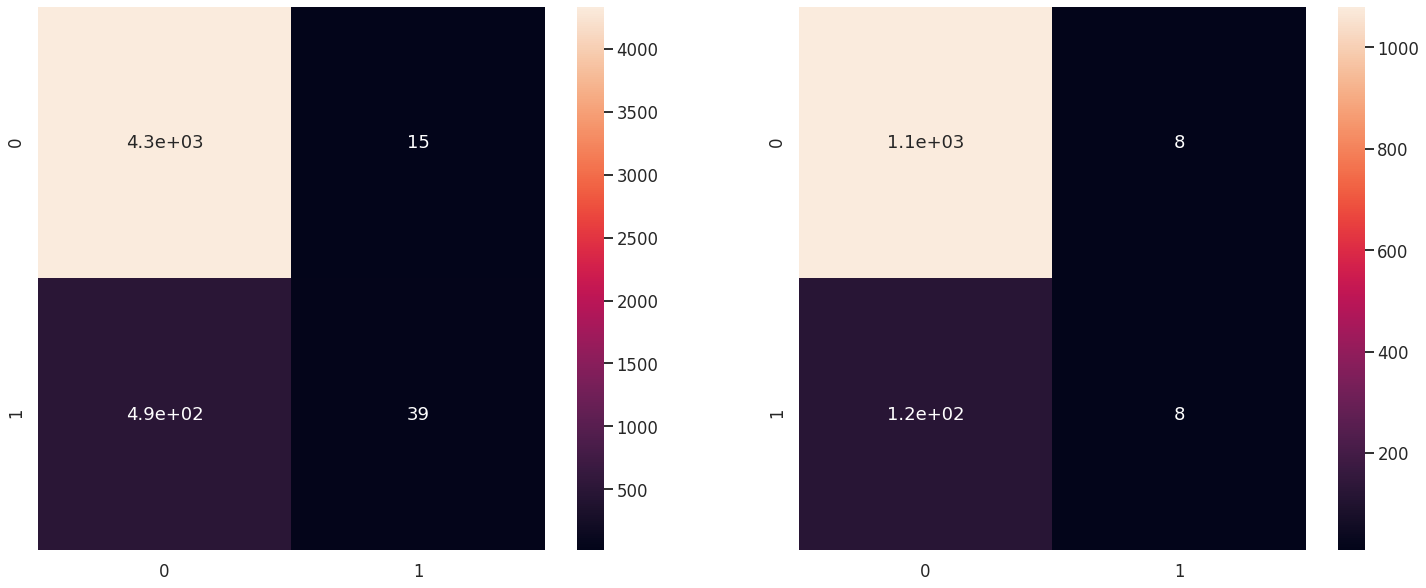

In [ ]:
model_matrix(y_train,
             y_test,
             lr_train_predict,
             lr_test_predict)

Train - Area Under the Curve: 0.78
Test - Area Under the Curve: 0.72


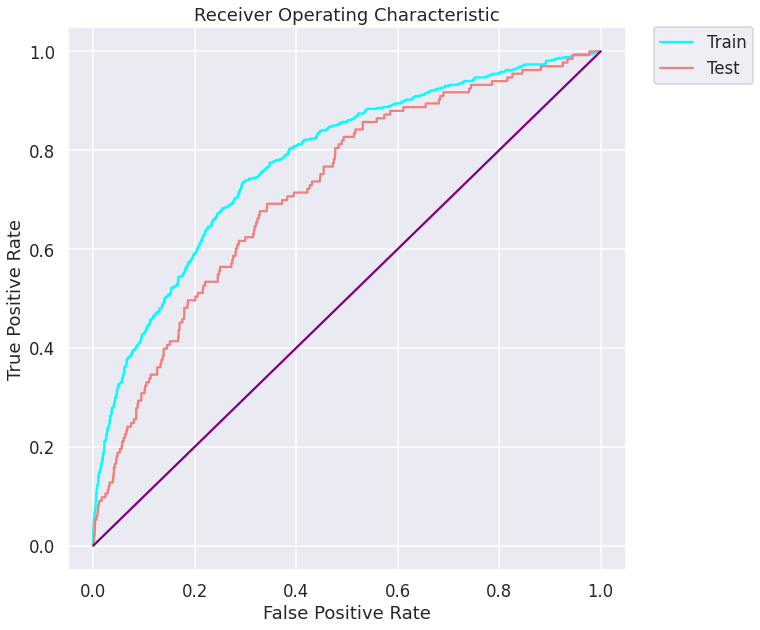

In [ ]:
model_roc(y_train,
          y_test,
          lr_train_probability,
          lr_test_probability)

## K Neighbors

In [ ]:
#Define model

kn = KNeighborsClassifier()

### Define Parameters

In [ ]:
# Define kn parameters for Grid Search

kn_params = {'leaf_size' : [1, 10, 20, 30, 40, 50],
             'weights' : ['uniform', 'distance'],
             'n_neighbors' : [1, 10, 20, 30],
             'p' : [1, 2]}

# Use Grid Search to find the best parameters for kn

model_grid(kn, kn_params)

{'leaf_size': 1, 'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}

In [ ]:
# Refine kn parameters for Grid Search

kn_best = KNeighborsClassifier(p = 1,
                               weights = 'uniform')

kn_params = {'leaf_size' : [1, 5],
             'n_neighbors' : [15, 20, 25]}

model_grid(kn_best, kn_params)

{'leaf_size': 1, 'n_neighbors': 20}

In [ ]:
# Define best paramters for kn

kn_best = KNeighborsClassifier(leaf_size = 1,
                               p = 1,
                               weights = 'uniform',
                               n_neighbors = 20)

### Fit Model

In [ ]:
kn_best.fit(x_train,
            y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=1,
                     weights='uniform')

In [ ]:
kn_train_predict = kn_best.predict(x_train)
kn_train_probability = kn_best.predict_proba(x_train)

kn_test_predict = kn_best.predict(x_test)
kn_test_probability = kn_best.predict_proba(x_test)

### Results

In [ ]:
model_report(y_train,
             y_test,
             kn_train_predict,
             kn_test_predict)

,Train - False,Test - False,Train - True,Test - True
precision,0.896324,0.895782,0.756098,0.583333
recall,0.997701,0.995404,0.058161,0.052632
f1-score,0.944299,0.942969,0.108014,0.096552
support,4350.000000,1088.000000,533.000000,133.000000


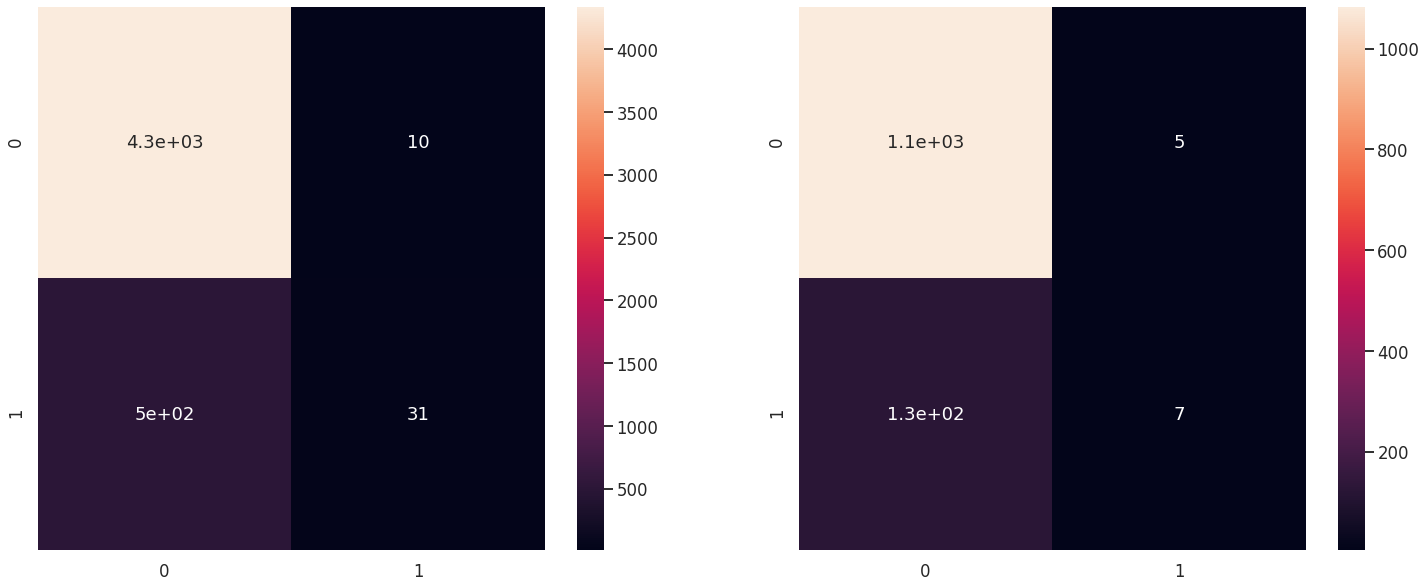

In [ ]:
model_matrix(y_train,
             y_test,
             kn_train_predict,
             kn_test_predict)

Train - Area Under the Curve: 0.8
Test - Area Under the Curve: 0.63


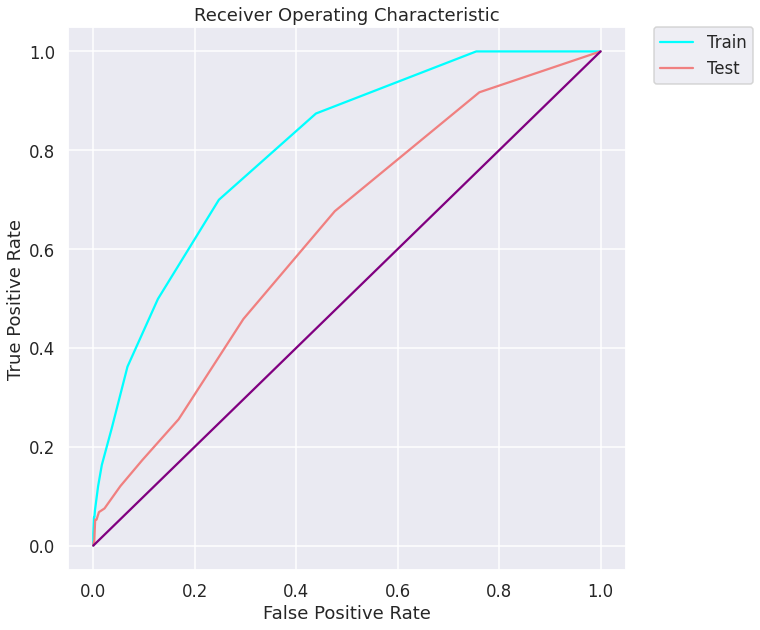

In [ ]:
model_roc(y_train,
          y_test,
          kn_train_probability,
          kn_test_probability)

## Decision Tree

In [ ]:
# Define model

dt = DecisionTreeClassifier()

### Define Parameters

In [ ]:
# Define dt parameters for Grid Search

dt_params = {'criterion' : ['gini', 'entropy'],
            'max_depth' : [1, 5, 10],
            'min_samples_split' : [1, 5, 10],
            'min_samples_leaf' : [1, 5]}

# Use Grid Search to find the best parameters for dt

model_grid(dt, dt_params)

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 5}

In [ ]:
dt_best = DecisionTreeClassifier(random_state = 13, 
                                 criterion = 'entropy',
                                 max_depth = 5,
                                 min_samples_leaf = 5,
                                 min_samples_split = 5)

### Fit Model

In [ ]:
dt_best.fit(x_train,
            y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=13, splitter='best')

In [ ]:
dt_train_predict = dt_best.predict(x_train)
dt_train_probability = dt_best.predict_proba(x_train)

dt_test_predict = dt_best.predict(x_test)
dt_test_probability = dt_best.predict_proba(x_test)

### Results

In [ ]:
model_report(y_train,
             y_test,
             dt_train_predict,
             dt_test_predict)

,Train - False,Test - False,Train - True,Test - True
precision,0.901250,0.900000,0.710843,0.619048
recall,0.994483,0.992647,0.110694,0.097744
f1-score,0.945574,0.944056,0.191558,0.168831
support,4350.000000,1088.000000,533.000000,133.000000


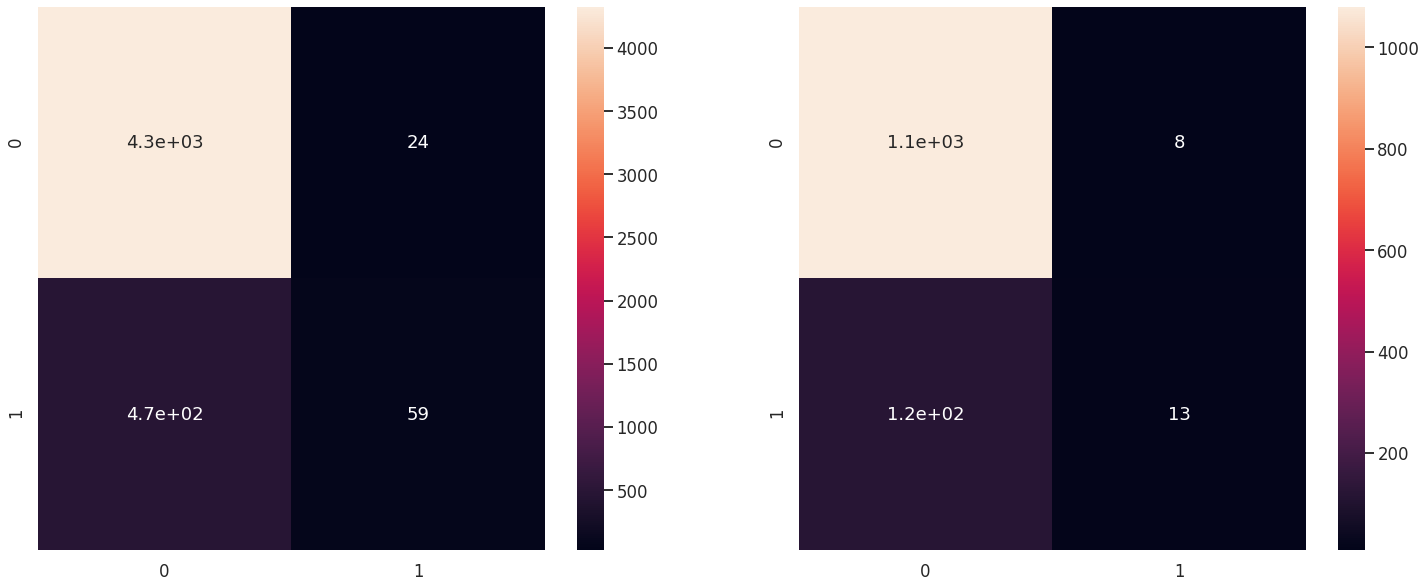

In [ ]:
model_matrix(y_train,
             y_test,
             dt_train_predict,
             dt_test_predict)

Train - Area Under the Curve: 0.78
Test - Area Under the Curve: 0.69


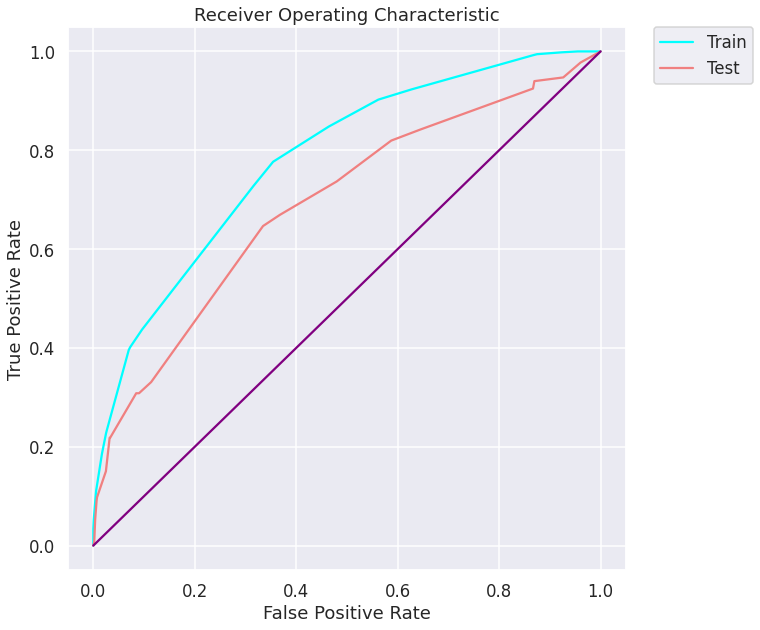

In [ ]:
model_roc(y_train,
          y_test,
          dt_train_probability,
          dt_test_probability)

## Extra Trees

In [ ]:
# Define Model

et = ExtraTreesClassifier(random_state = 13)

In [ ]:
# Define et parameters for Grid Search

et_params = {'max_depth' : [10, 50, 100],
            'min_samples_split' : [2, 5, 10],
            'min_samples_leaf' : [1, 5]}

# Use Grid Search to find the best parameters for et

model_grid(et, et_params)

{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [ ]:
# Refine et parameters for Grid Search

et_params = {'max_depth' : [5, 10, 15]}

model_grid(et, et_params)

{'max_depth': 5}

In [ ]:
# Define best paramters for et

et_best = ExtraTreesClassifier(random_state = 13, 
                               max_depth = 5, 
                               min_samples_leaf = 5, 
                               min_samples_split = 2)

### Fit Model

In [ ]:
et_best.fit(x_train, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=5, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=5, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=13, verbose=0,
                     warm_start=False)

In [ ]:
et_train_predict = et_best.predict(x_train)
et_train_probability = et_best.predict_proba(x_train)

et_test_predict = et_best.predict(x_test)
et_test_probability = et_best.predict_proba(x_test)

### Results

In [ ]:
model_report(y_train,
             y_test,
             et_train_predict,
             et_test_predict)

,Train - False,Test - False,Train - True,Test - True
precision,0.896324,0.895782,0.756098,0.583333
recall,0.997701,0.995404,0.058161,0.052632
f1-score,0.944299,0.942969,0.108014,0.096552
support,4350.000000,1088.000000,533.000000,133.000000


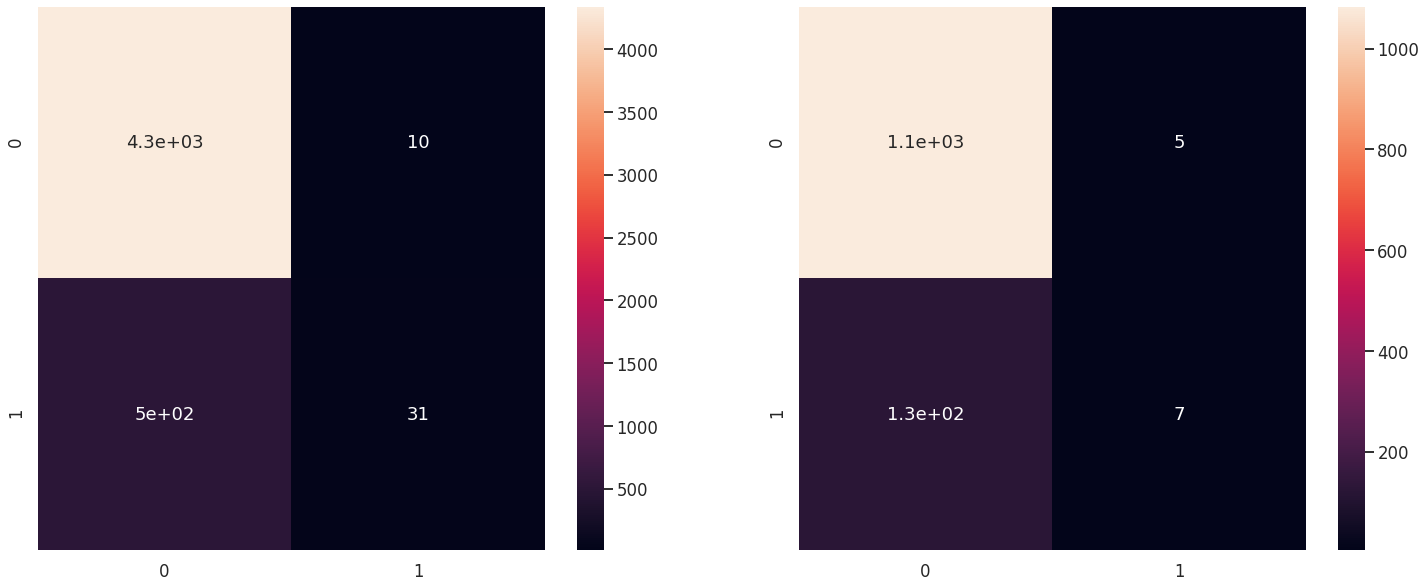

In [ ]:
model_matrix(y_train,
             y_test,
             et_train_predict,
             et_test_predict)

Train - Area Under the Curve: 0.77
Test - Area Under the Curve: 0.7


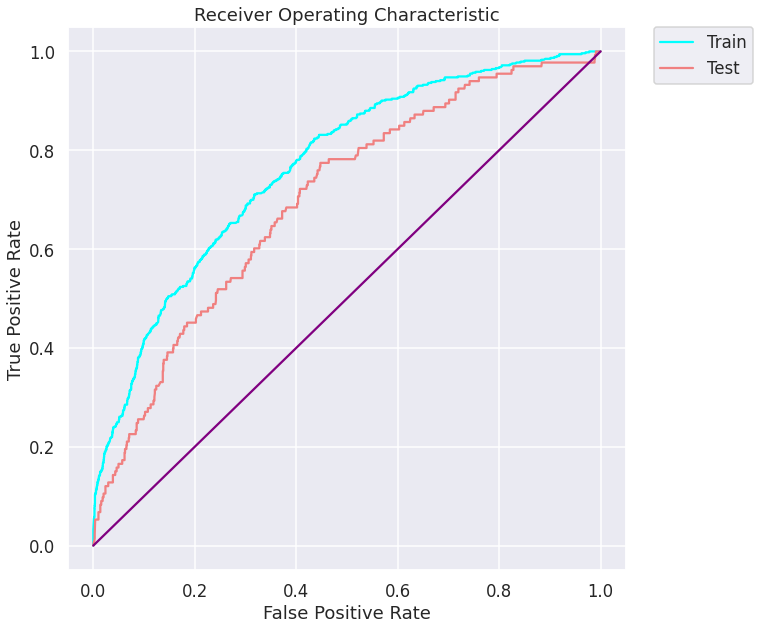

In [ ]:
model_roc(y_train,
          y_test,
          et_train_probability,
          et_test_probability)

## Random Forest

In [ ]:
# Define model

rf = RandomForestClassifier()

### Define Parameters

In [ ]:
# Define rf parameters for Grid Search

rf_params = {'n_estimators' : [100, 150, 200],
             'criterion' :['gini', 'entropy'],
             'max_depth' : [10, 50, 100],
             'min_samples_split' : [2, 5, 10],
             'min_samples_leaf' : [1, 5]}

# Use Grid Search to find the best parameters for rf

model_grid(rf, rf_params)

{'criterion': 'gini',
 'max_depth': 50,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 200}

In [ ]:
# Refine rf parameters for Grid Search

rf_best = RandomForestClassifier(criterion = 'gini',
                                 min_samples_leaf = 5,
                                 min_samples_split = 5)

rf_params = {'n_estimators' : [200, 250],
             'max_depth' : [40, 50, 60]}

model_grid(rf_best, rf_params)

{'max_depth': 60, 'n_estimators': 200}

In [ ]:
# Refine rf parameters for Grid Search

rf_best = RandomForestClassifier(n_estimators = 200,
                                 criterion = 'gini',
                                 min_samples_split = 5,
                                 min_samples_leaf = 5)

rf_params = {'max_depth' : [60, 70, 80]}

model_grid(rf_best, rf_params)

{'max_depth': 80}

In [ ]:
# Define best paramters for rf

rf_best = RandomForestClassifier(n_estimators = 200,
                                 criterion = 'gini',
                                 max_depth = 80,
                                 min_samples_split = 5,
                                 min_samples_leaf = 5)

### Fit Model

In [ ]:
rf_best.fit(x_train,
            y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
rf_train_predict = rf_best.predict(x_train)
rf_train_probability = rf_best.predict_proba(x_train)

rf_test_predict = rf_best.predict(x_test)
rf_test_probability = rf_best.predict_proba(x_test)

### Results

In [ ]:
model_report(y_train,
             y_test,
             rf_train_predict,
             rf_test_predict)

,Train - False,Test - False,Train - True,Test - True
precision,0.899419,0.895868,0.786885,0.636364
recall,0.997011,0.996324,0.090056,0.052632
f1-score,0.945704,0.943429,0.161616,0.097222
support,4350.000000,1088.000000,533.000000,133.000000


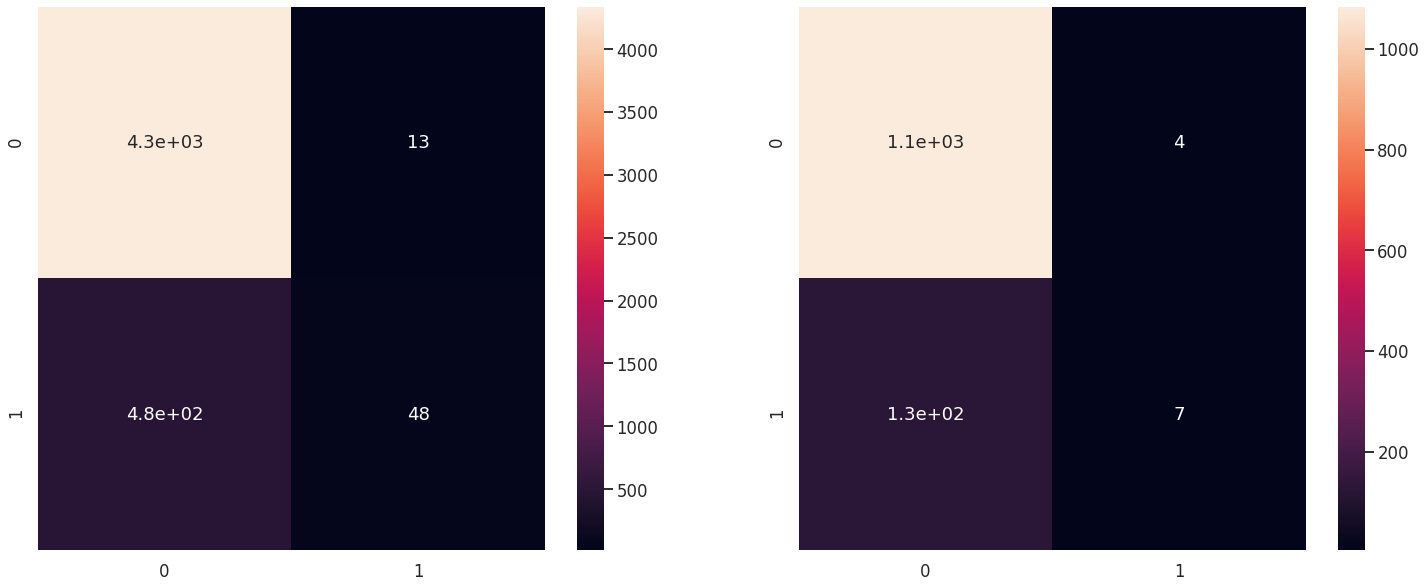

In [ ]:
model_matrix(y_train,
             y_test,
             rf_train_predict,
             rf_test_predict)

Train - Area Under the Curve: 0.93
Test - Area Under the Curve: 0.72


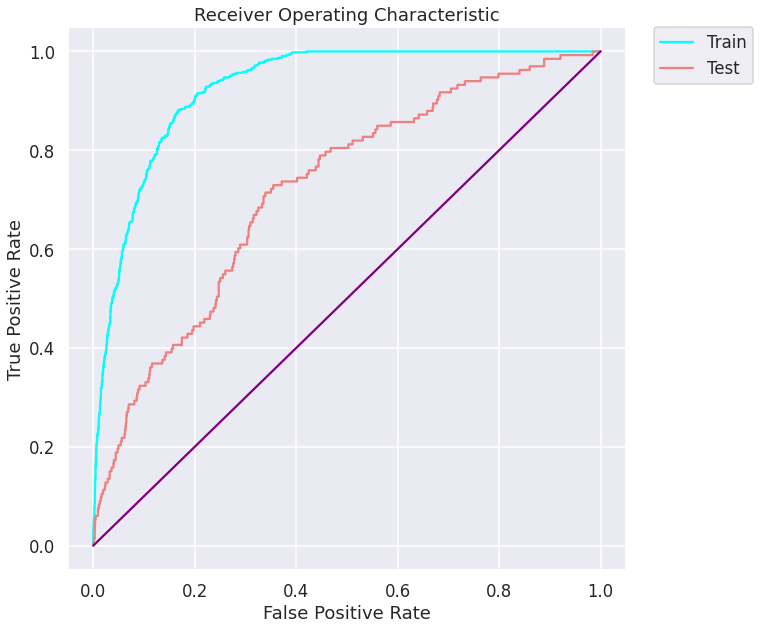

In [ ]:
model_roc(y_train,
          y_test,
          rf_train_probability,
          rf_test_probability)

## AdaBoost

In [ ]:
# Define Model

ada = AdaBoostClassifier(random_state = 13)

### Define Parameters

In [ ]:
# Define ada parameters for Grid Search

ada_params = {'base_estimator' : [dt_best, et_best, rf_best]}

# Use Grid Search to find the best parameters for ada

model_grid(ada, ada_params)

{'base_estimator': ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=5, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=13, verbose=0,
                      warm_start=False)}

In [ ]:
# Refine ada parameters for Grid Search

ada_best = AdaBoostClassifier(base_estimator = et_best,
                              random_state = 13)

ada_params = {'n_estimators' : [10, 50, 100],
             'learning_rate' : [0.5, 1]}

model_grid(ada_best, ada_params)

{'learning_rate': 0.5, 'n_estimators': 10}

In [ ]:
# Define ada parameters for Grid Search

ada_best = AdaBoostClassifier(base_estimator = et_best,
                              learning_rate = 0.5,
                              n_estimators =  10,
                              random_state = 13)

### Fit Model

In [ ]:
ada_best.fit(x_train,
             y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=ExtraTreesClassifier(bootstrap=False,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=5,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=5,
                                                       min_samples_split=2,
                                                       min_weight

In [ ]:
ada_train_predict = ada_best.predict(x_train)
ada_train_probability = ada_best.predict_proba(x_train)

ada_test_predict = ada_best.predict(x_test)
ada_test_probability = ada_best.predict_proba(x_test)

### Results

In [ ]:
model_report(y_train,
             y_test,
             ada_train_predict,
             ada_test_predict)

,Train - False,Test - False,Train - True,Test - True
precision,0.896509,0.895695,0.761905,0.538462
recall,0.997701,0.994485,0.060038,0.052632
f1-score,0.944402,0.942509,0.111304,0.095890
support,4350.000000,1088.000000,533.000000,133.000000


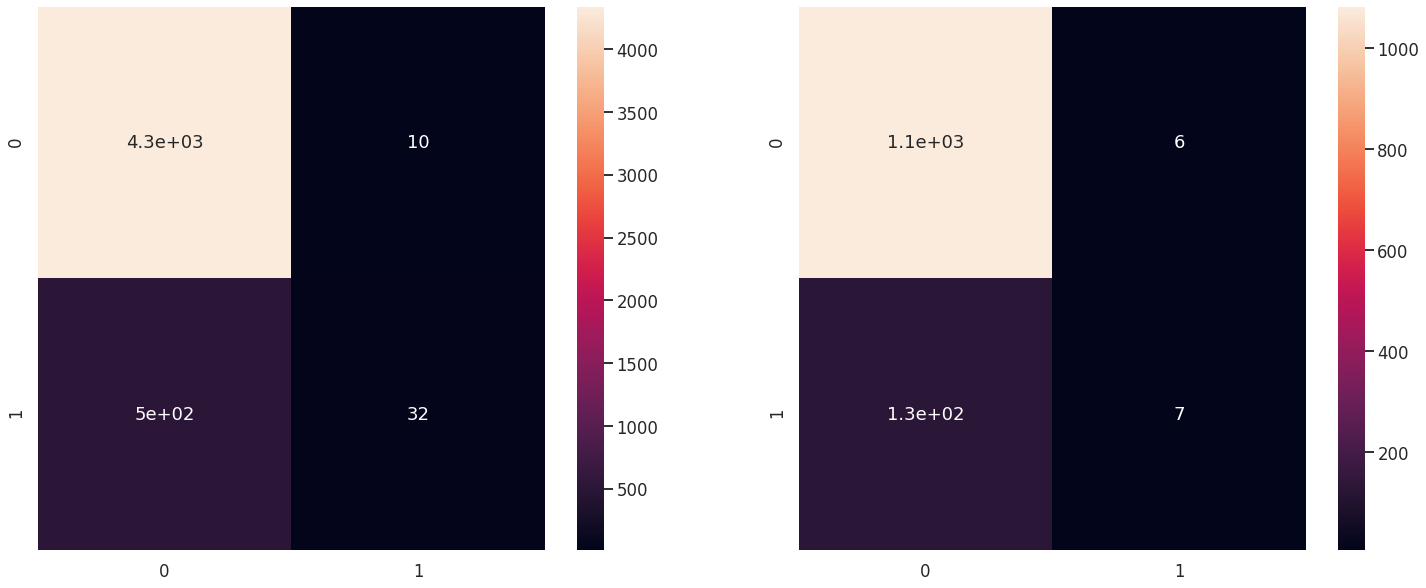

In [ ]:
model_matrix(y_train,
             y_test,
             ada_train_predict,
             ada_test_predict)

Train - Area Under the Curve: 0.81
Test - Area Under the Curve: 0.7


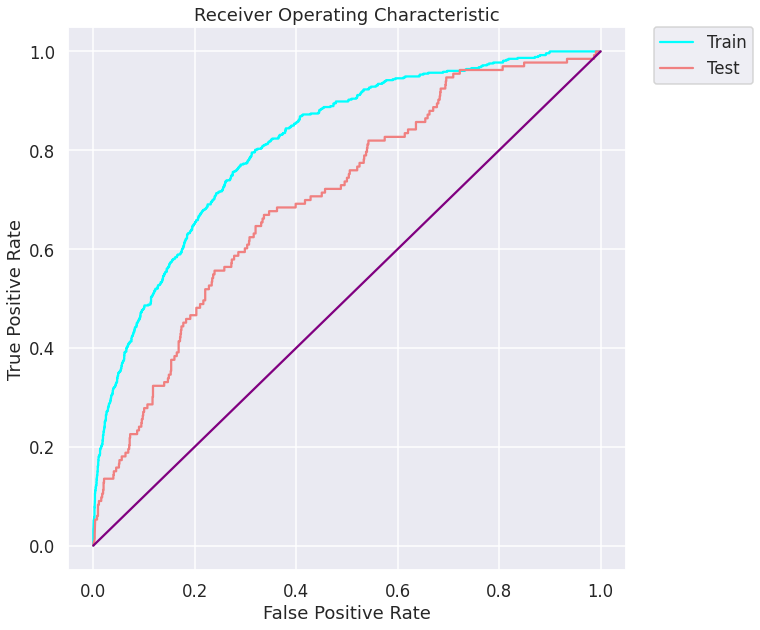

In [ ]:
model_roc(y_train,
          y_test,
          ada_train_probability,
          ada_test_probability)

## Gradient Boost

In [ ]:
# Define model

gb = GradientBoostingClassifier()

### Define Parameters

In [ ]:
# Define gb parameters for Grid Search

gb_best = GradientBoostingClassifier(random_state = 13)

# Use Grid Search to find the best parameters for gb

gb_params = {'n_estimators' : [50, 100, 150],
             'learning_rate' : [0.01, 0.1, 1]}

model_grid(gb_best, gb_params)

{'learning_rate': 0.01, 'n_estimators': 150}

In [ ]:
# Define best paramters for gb

gb_best = AdaBoostClassifier(random_state = 13,
                             n_estimators = 150,
                             learning_rate = 0.1)

### Fit Model

In [ ]:
gb_best.fit(x_train,
            y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=150, random_state=13)

In [ ]:
gb_train_predict = gb_best.predict(x_train)
gb_train_probability = gb_best.predict_proba(x_train)

gb_test_predict = gb_best.predict(x_test)
gb_test_probability = gb_best.predict_proba(x_test)

### Results

In [ ]:
model_report(y_train,
             y_test,
             gb_train_predict,
             gb_test_predict)

,Train - False,Test - False,Train - True,Test - True
precision,0.896858,0.895695,0.755556,0.538462
recall,0.997471,0.994485,0.063790,0.052632
f1-score,0.944493,0.942509,0.117647,0.095890
support,4350.000000,1088.000000,533.000000,133.000000


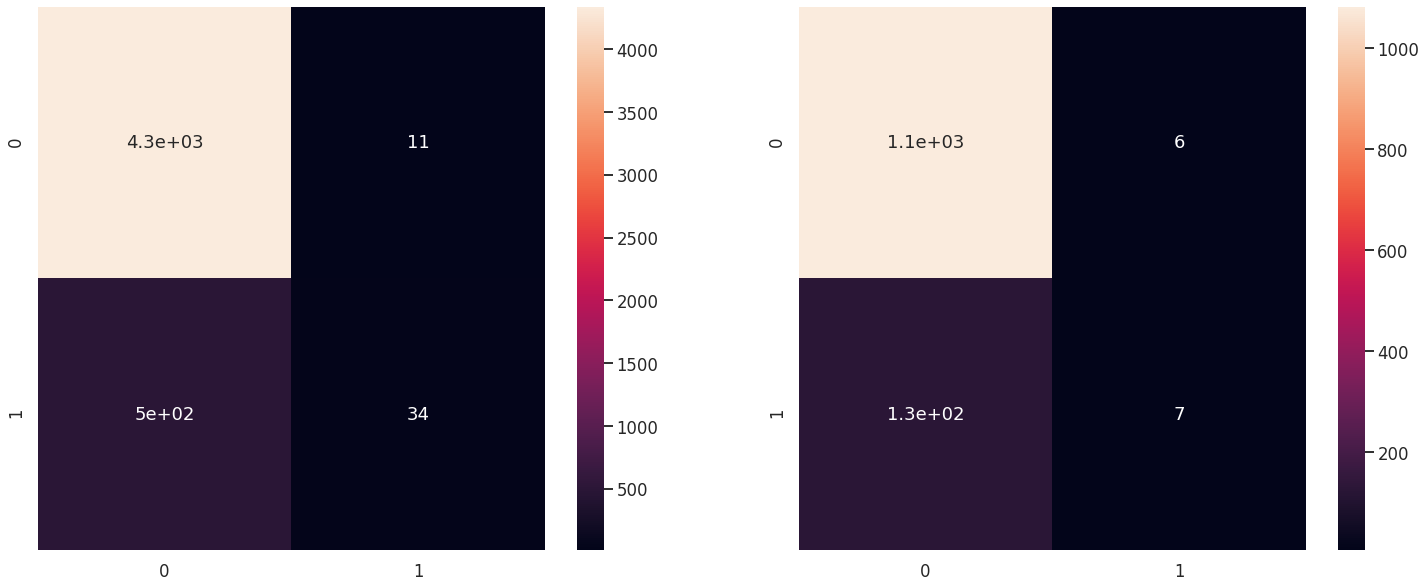

In [ ]:
model_matrix(y_train,
             y_test,
             gb_train_predict,
             gb_test_predict)

Train - Area Under the Curve: 0.79
Test - Area Under the Curve: 0.72


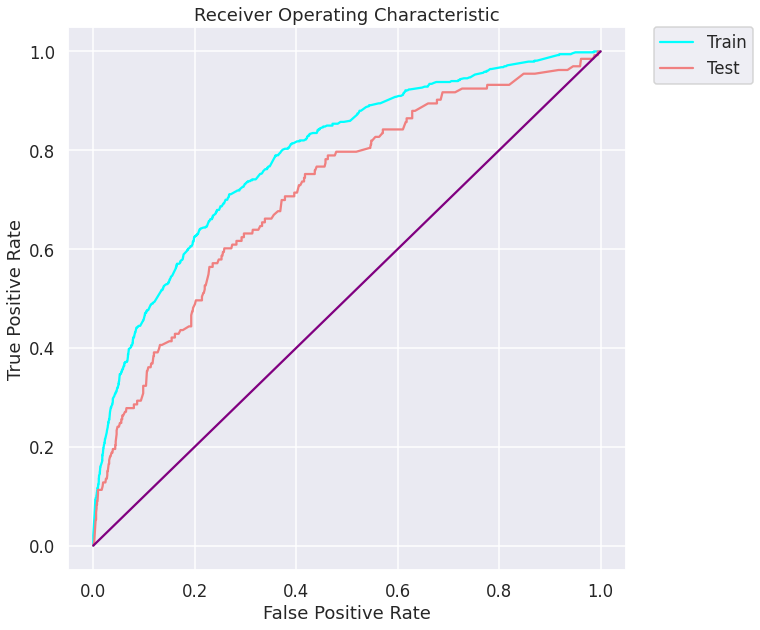

In [ ]:
model_roc(y_train,
          y_test,
          gb_train_probability,
          gb_test_probability)

## XG Boost

In [ ]:
# Define model

xgb1 = xgb.XGBClassifier()

### Define Parameters

In [ ]:
# Define xgb parameters for Grid Search
# Use Grid Search to find the best parameters for xgb

xgb_params = {'eta' : [0.05, 0.1, 0.15],
             'max_depth' : [5, 10, 15],
             'subsample' : [0.5, 1],
             'objective' : ['binary:logistic', 'binary:logitraw', 'binary:hinge']}

model_grid(xgb1, xgb_params)

{'eta': 0.05, 'max_depth': 5, 'objective': 'binary:logitraw', 'subsample': 1}

In [ ]:
# Define best paramters for xgb

xgb_best = xgb.XGBClassifier(eta = 0.05,
                             max_depth = 5,
                             objective = 'binary:logistic',
                             subsample = 1)

### Fit Model

In [ ]:
xgb_best.fit(x_train,
             y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.05, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_train_predict = xgb_best.predict(x_train)
xgb_train_probability = xgb_best.predict_proba(x_train)

xgb_test_predict = xgb_best.predict(x_test)
xgb_test_probability = xgb_best.predict_proba(x_test)

### Results

In [ ]:
model_report(y_train,
             y_test,
             xgb_train_predict,
             xgb_test_predict)

,Train - False,Test - False,Train - True,Test - True
precision,0.912229,0.899749,0.878788,0.541667
recall,0.996322,0.989890,0.217636,0.097744
f1-score,0.952423,0.942670,0.348872,0.165605
support,4350.000000,1088.000000,533.000000,133.000000


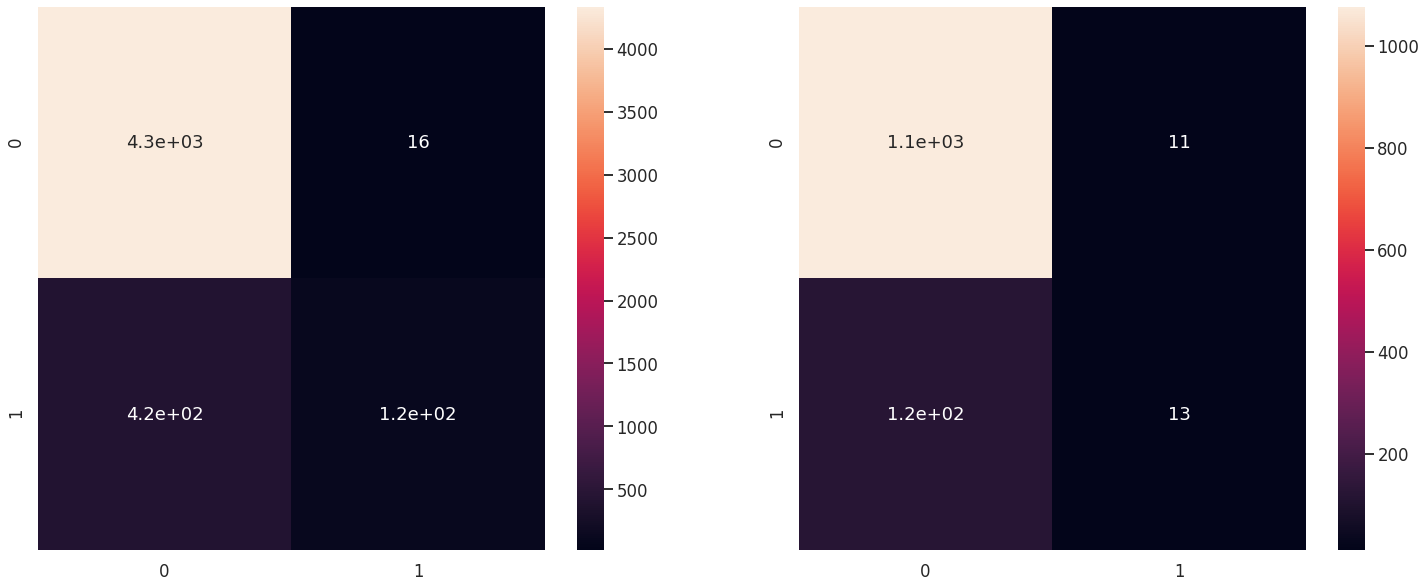

In [ ]:
model_matrix(y_train,
             y_test,
             xgb_train_predict,
             xgb_test_predict)

Train - Area Under the Curve: 0.89
Test - Area Under the Curve: 0.71


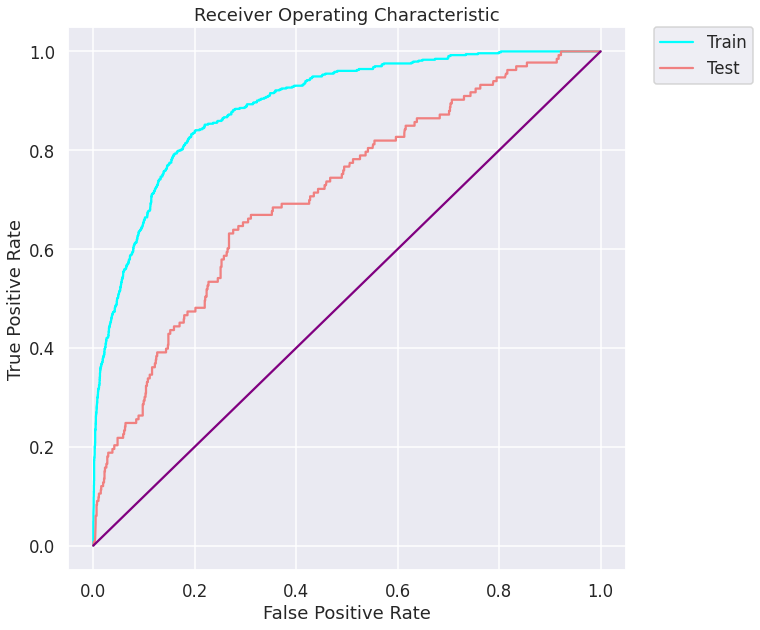

In [ ]:
model_roc(y_train,
          y_test,
          xgb_train_probability,
          xgb_test_probability)

# Compare Models

In [ ]:
  model_names = ['Logistic Regression',
                 'K Neighbors',
                 'Decision Tree',
                 'Extra Trees',
                 'Random Forest',
                 'AdaBoost',
                 'Gradient Boost',
                 'XG Boost']
models = [lr,
          kn,
          dt,
          et,
          rf,
          ada,
          gb,
          xgb]

probabilities = [lr_test_probability,
                 kn_test_probability,
                 dt_test_probability,
                 et_test_probability,
                 rf_test_probability,
                 ada_test_probability,
                 gb_test_probability,
                 xgb_test_probability]

roc_scores = []
for p in probabilities:
    roc_scores.append(round(roc_auc_score(y_test, p[:,1]),2))



model_comparison = pd.DataFrame(model_names, columns = ['Model'])
model_comparison['ROC'] = roc_scores

model_comparison.sort_values('ROC',
                             ascending = False,
                             inplace = True)

,Model,Score
0,Logistic Regression,0.72
1,K Neighbors,0.63
2,Decision Tree,0.69
3,Extra Trees,0.70
4,Random Forest,0.72
5,AdaBoost,0.70
6,Gradient Boost,0.72
7,XG Boost,0.71


In [ ]:
model_comparison

,Model,Score
0,Logistic Regression,0.72
4,Random Forest,0.72
6,Gradient Boost,0.72
7,XG Boost,0.71
3,Extra Trees,0.70
5,AdaBoost,0.70
2,Decision Tree,0.69
1,K Neighbors,0.63


# Build Ensemble Model

In [ ]:
estimators = [('xgb', xgb_best),
              ('rf', rf_best),
              ('gb', gb_best)]

ensemble = VotingClassifier(estimators,
                            voting = 'soft')

### Fit Model

In [ ]:
ensemble.fit(x_train,
             y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, eta=0.05,
                                            gamma=0, learning_rate=0.1,
                                            max_delta_step=0, max_depth=5,
                                            min_child_weight=1, missing=None,
                                            n_estimators=100, n_jobs=1,
                                            nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_p...
                                                     min_impurity_split=None,
                                  

In [ ]:
ensemble_train_predict = ensemble.predict(x_train)
ensemble_train_probability = ensemble.predict_proba(x_train)

ensemble_test_predict = ensemble.predict(x_test)
ensemble_test_probability = ensemble.predict_proba(x_test)

### Results

In [ ]:
model_report(y_train,
             y_test,
             ensemble_train_predict,
             ensemble_test_predict)

,Train - False,Test - False,Train - True,Test - True
precision,0.897765,0.895695,0.764706,0.538462
recall,0.997241,0.994485,0.073171,0.052632
f1-score,0.944892,0.942509,0.133562,0.095890
support,4350.000000,1088.000000,533.000000,133.000000


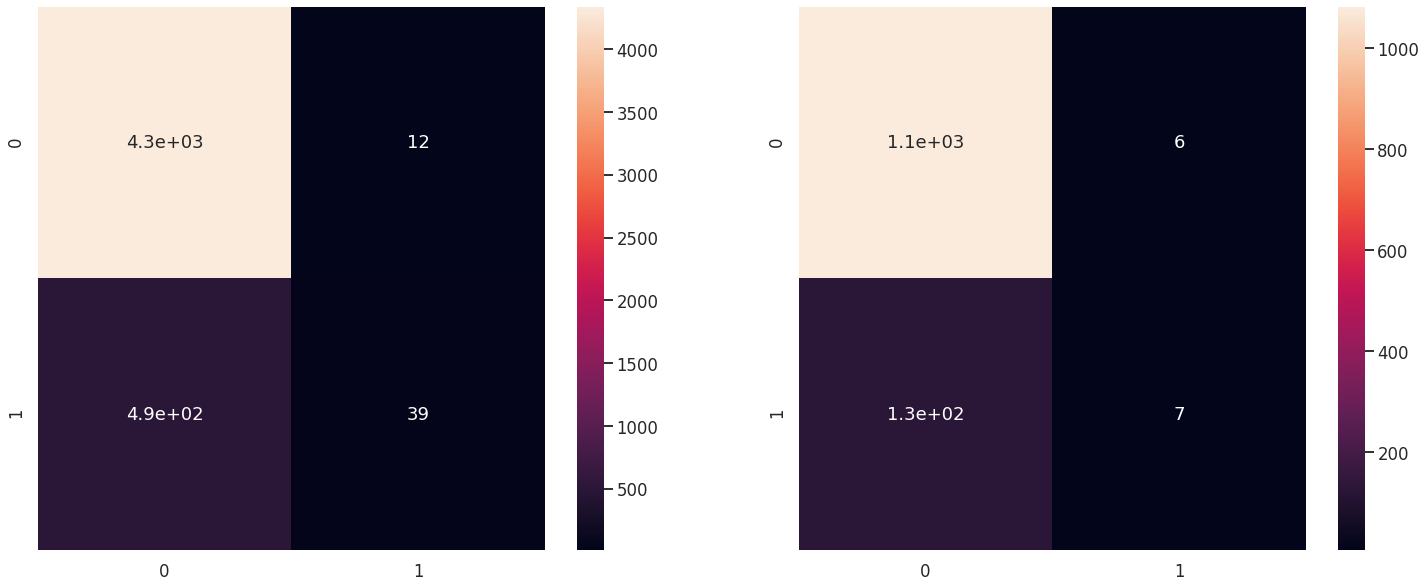

In [ ]:
model_matrix(y_train,
             y_test,
             ensemble_train_predict,
             ensemble_test_predict)

Train - Area Under the Curve: 0.87
Test - Area Under the Curve: 0.73


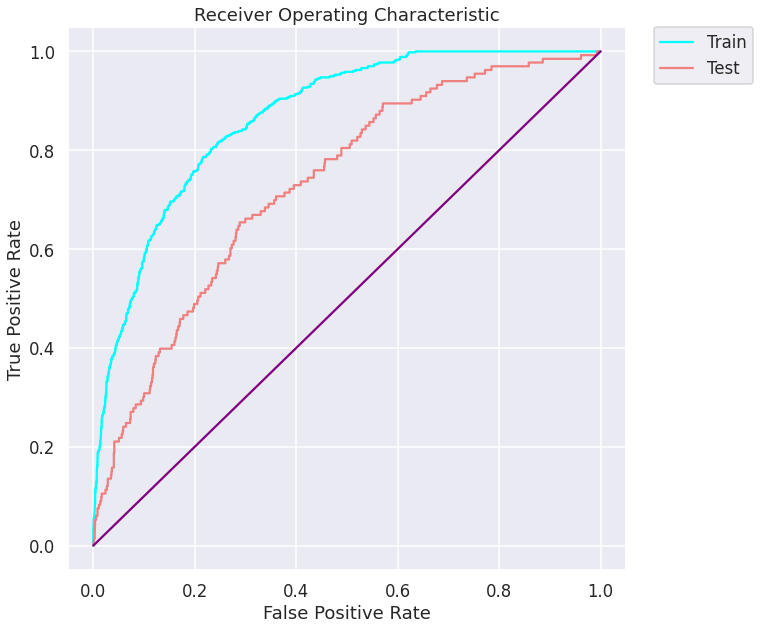

In [ ]:
model_roc(y_train,
          y_test,
          ensemble_train_probability,
          ensemble_test_probability)

# Feature Importance

In [ ]:
# Visualize Feature Importance

def model_fi(model):
    fi = (pd.DataFrame(model.feature_importances_,
                       index = x.columns, 
          columns = ['importance']).sort_values('importance',
                                                ascending = False))
    fig, ax = plt.subplots(figsize = (10, 20))
    sns.barplot(x = 'importance',
                y = x.columns, 
                data = fi,
                color = 'purple')
    ax.set_title('Feature Importance')
    plt.show()

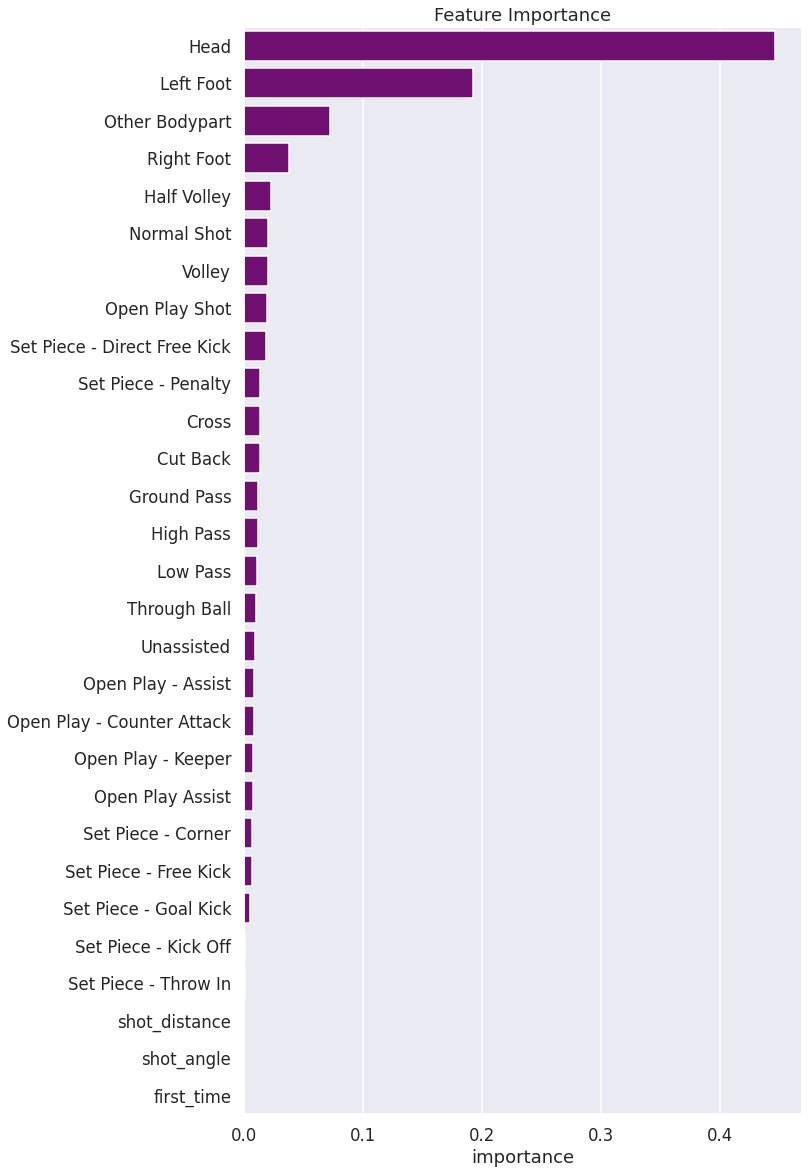

In [ ]:
model_fi(rf_best)

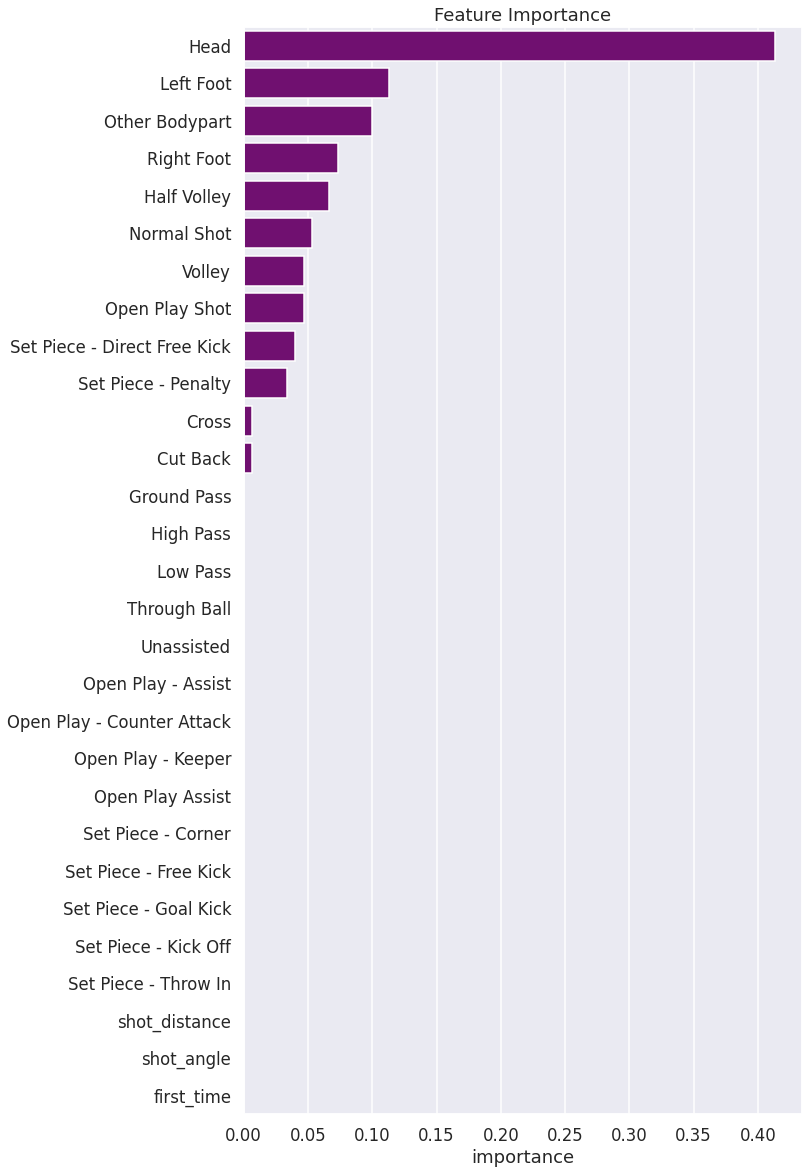

In [ ]:
model_fi(gb_best)

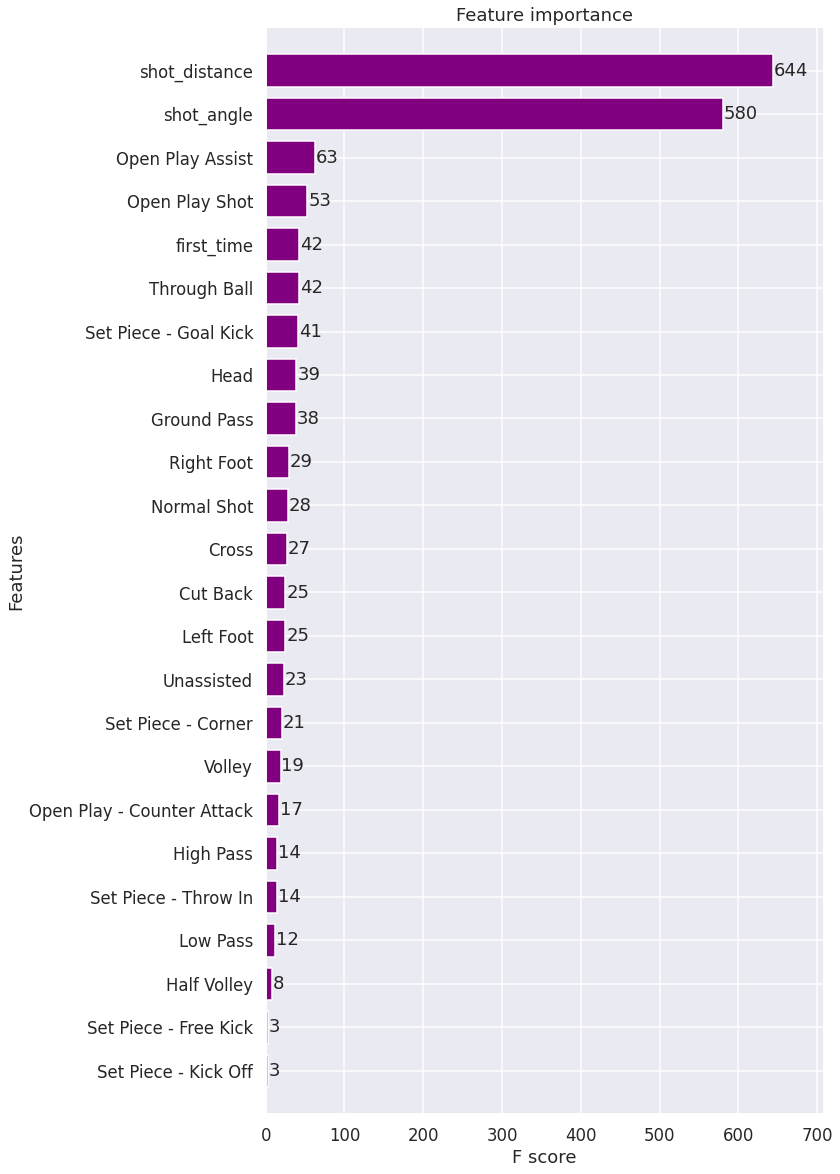

In [ ]:
# Calculate and visualize the Feature Importance for the XGB Boost model

fig, ax = plt.subplots(figsize = (10, 20))
xgb.plot_importance(xgb_best, ax = ax, color = 'purple', height = 0.75)
plt.show()

In [ ]:
preprocessed_data = encoded_data
preprocessed_data.to_csv('/content/drive/MyDrive/flatiron/expected_goals/data_preprocessing/preprocessed_data.csv')

Continued in [expected_goals_data_modeling_notebook](https://github.com/wswager/expected_goals/blob/main/data_modeling/expected_goals_data_modeling_notebook.ipynb)